# Development ideas 

This notebook compiles different development ideas which, I think, are worth exploring.

* Using the Transformer architecture
* Adaptative $\epsilon$-greedy sampling
* Dropout for TD3 approximation 


## Using the Transformer architecture - *done*

One of the easily dropped assumption in RL task is the Markov property, that is, the current state is a sufficient statistic of the previous states.

The Transformer architecture seems to respect this property, at least there is nothing clearly breaking it:
- The state, for each agent, is the agent input and its current target, iteratively constructed through greedy decoding. Hence, it keeps all states in memory during the task.
- Attention layers connect every elements of the state to each other, so the current state interacts with all previous states.



## Adaptative $\epsilon$-greedy sampling - *done*

When running the encoder, it appears that while some batches' action values correctly converged, some are still hitting low, even if, in this task, all state values should converge to $1$. 

All actions are sampled according to the same $\epsilon$-greedy distribution, which means that they have the same exploration rate, but could it be more adaptative ?

My idea is to set $\epsilon$ batch-wised according to a function $f_\epsilon$ of the state value $v$, satisfying the following:

1. $f_\epsilon(v) \in (0,1)$.

2. if $v$ is close to $1$, then $\epsilon = f_\epsilon(v)$ is close to $0$,

3. if $v$ is far from $1$, then $\epsilon = f_\epsilon(v)$ is close to $1$.

More mathematically speaking, a function satisfying:

1. $\forall v \in \mathbb(R), f_\epsilon(v) \in (0,1)$,

2. $\lim_{\lVert v-1 \lVert\to 0} f_\epsilon(v) = 0$,

3. $\lim_{\lVert v-1\lVert\to\infty} f_\epsilon(v) = 1$.

To satisfy the first point, a sigmoid function $x \mapsto \frac{1}{1+e^{-x}}$ seems appropriate, while the other points indicates a logarithm of the distance $x \mapsto \ln{(\lVert x-1 \lVert)}$.

Simplificitation leads to tis appropriate function:

$$f_\epsilon: v \mapsto \frac{\lVert v-1 \lVert}{\lVert v-1 \lVert + 1} $$


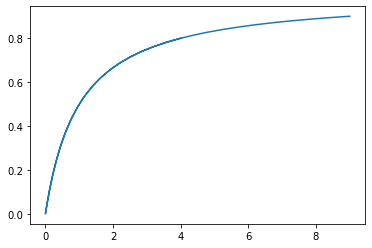

In [21]:

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-2, 3)
y = (x-1)**2/((x-1)**2+1)
x = (x-1)**2

plt.plot(x, y)

For more efficiency, just as sigmoid has been commonly replaced by reLu, one could use a ramp function for $\lVert v-1 \lVert$: 

$$f_\epsilon : v \mapsto \begin{cases} \frac{\lVert v-1 \lVert}{d} & \mbox{if } \lVert v-1 \lVert \in (0, d), \\ 1 & \mbox{if } \lVert v-1 \lVert \ge d.\end{cases}$$

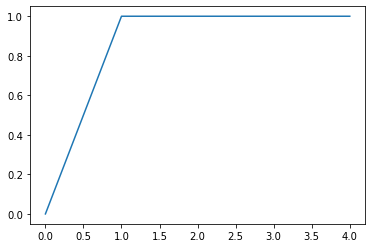

In [56]:
x = np.linspace(-1, 2)
x = (x-1)**2
x = np.sort(x)
y = x.copy()
d = 1
y[y>=d] = 1


plt.plot(x, y)

For the sake of metaphore, adaptative $\epsilon$ corresponds to action sampling under panic.

Basically, when you forgot yout keys, there are two options.

If you know you've put them on my desk, you just go check the desk.

If you don't, you'll start looking on the desk, then on the floor, the fridge, the toaster, in a drawer you've never touched, inside a book... and one might work!


To ensure minimum exploration, $\epsilon_{min}$, the following transformation can be applied:

$$f_{\epsilon min}: v \mapsto (1-f_\epsilon(v))(1-\epsilon_{min})$$

This transformation keeps the previous properties, except that $\epsilon > \epsilon_{min}$.



## Dropout for TD3 approximation

Due to overestimation and instability issues, I've searched for solutions in recent papers. One of them, [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/pdf/1802.09477.pdf#cite.DDPG), suggests one approach:

- Clipped Double Q-Learning for Actor-Critic:

In order to tackle overestimation bias, taking the minimum value between a pair of critics (and actors) reduces overestimation:

$$y_1 = r + \gamma \min_{i=1,2} Q_{\theta'i}(s', \pi_{\phi1}(s'))$$

This and other improvments result in an algorithm called TD3.

Due to limited computing resources, I've imagined an approximation of the TD3 algorithm, using dropout.

Instead of using two different networks, which can be expensive at some point, using dropout simulates having several networks, for almost free. Also, instead of taking the minimum between two values, it becomes straightforward to take as many values as wanted.

Although this infringes model understanding and some of the papers conditions, due to simplicity and the benefit of dropout in supervised learning, it is worth the try.


## Beam Search vs Greedy Decoding

The current models implement a Greedy Decoding way of giving ouputs.

